### 1. Приводим датасет к рабочему виду

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install chardet # только так удалось прочесть файл

In [3]:
import pandas as pd
import chardet

file_path = '/content/drive/MyDrive/Colab Notebooks/socialmedia_relevant_cols.csv'
with open(file_path, 'rb') as file:
    result = chardet.detect(file.read())
    encoding = result['encoding']

data = pd.read_csv(file_path, encoding='ISO-8859-1', on_bad_lines='skip')

In [4]:
data.columns = ['text', 'choose_one', 'class_label']

data['class_label'] = data['class_label'].str.replace(';', '')

data.head(10)

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,Forest fire near La Ronge Sask. Canada,Relevant,1
3,All residents asked to 'shelter in place' are ...,Relevant,1
4,Just got sent this photo from Ruby #Alaska as ...,Relevant,1
5,#RockyFire Update => California Hwy. 20 closed...,Relevant,1
6,Apocalypse lighting. #Spokane #wildfires,Relevant,1
7,Typhoon Soudelor kills 28 in China and Taiwan,Relevant,1
8,We're shaking...It's an earthquake,Relevant,1
9,I'm on top of the hill and I can see a fire in...,Relevant,1


### 2. Предобработка постов

In [5]:
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS

nlp = spacy.load('en_core_web_sm')

def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#', '', text)
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
    return ' '.join(tokens)

data['clean_text'] = data['text'].apply(clean_text)

print(data[['text', 'clean_text']].head())

                                                text  \
0                 Just happened a terrible car crash   
1  Our Deeds are the Reason of this #earthquake M...   
2             Forest fire near La Ronge Sask. Canada   
3  All residents asked to 'shelter in place' are ...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0                          happen terrible car crash  
1               deed reason earthquake allah forgive  
2              forest fire near la ronge sask canada  
3  resident ask shelter place notify officer evac...  
4  get send photo ruby alaska smoke wildfires pou...  


### 3. Визуализация специфики датасета

In [6]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns

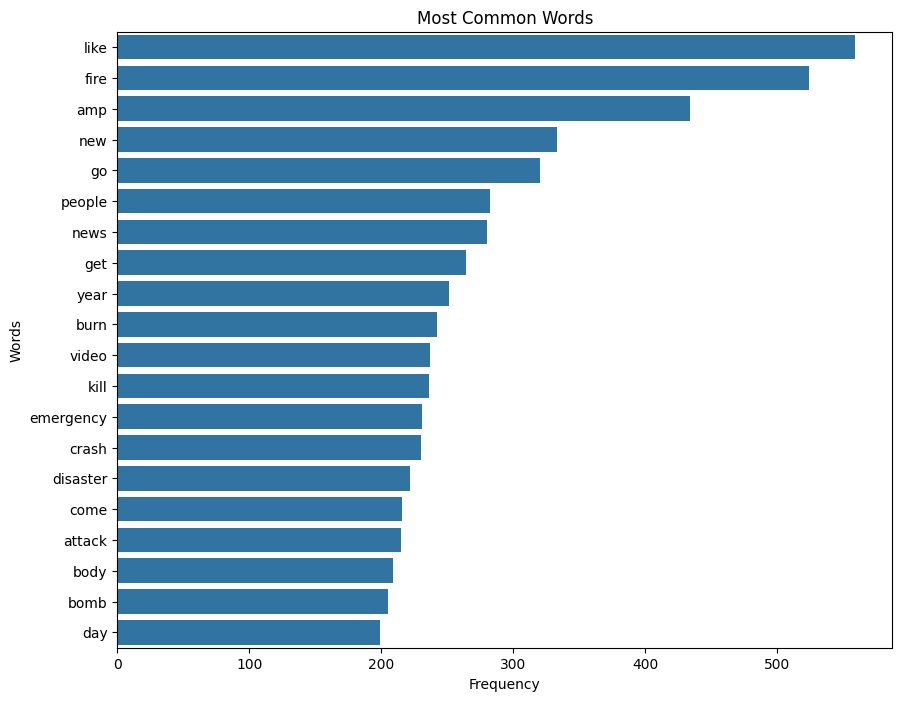

In [7]:
data['tokens'] = data['clean_text'].apply(lambda x: x.split())

# список всех слов
all_words = [word for tokens in data['tokens'] for word in tokens]
word_freq = Counter(all_words)

most_common_words = word_freq.most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title('Most Common Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()

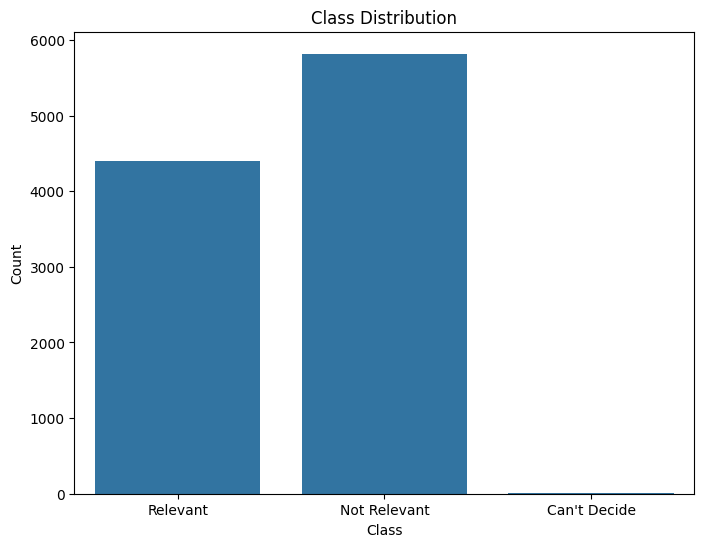

In [8]:
# распределение классов
plt.figure(figsize=(8, 6))
sns.countplot(x='choose_one', data=data)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

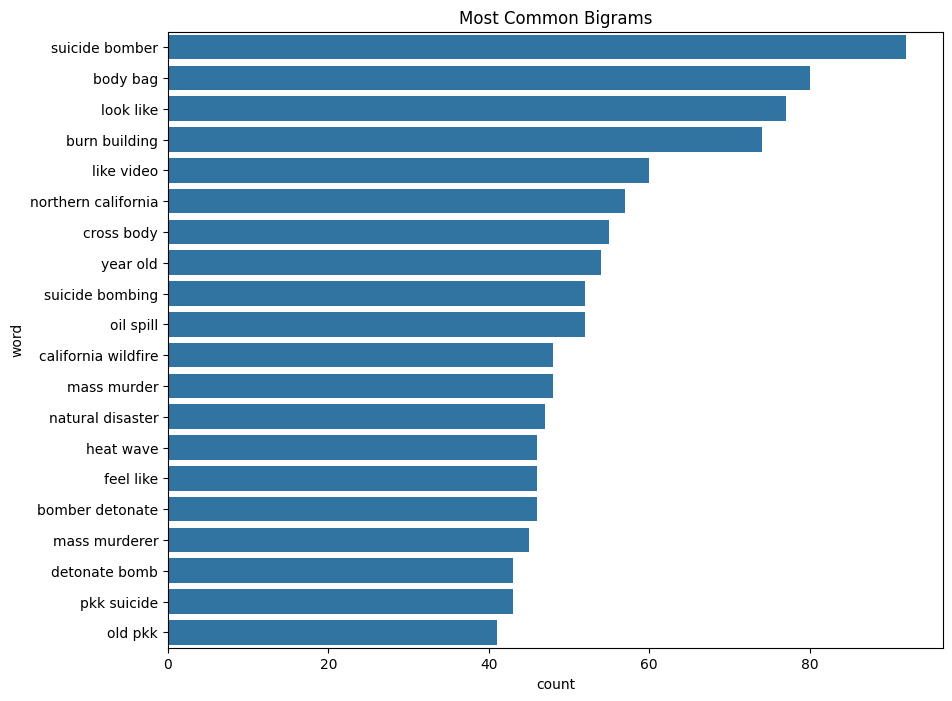

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

# построения наиболее распространенных n-грамм
def plot_ngrams(n, title):
    vec = CountVectorizer(ngram_range=(n, n), stop_words='english').fit(data['clean_text'])
    bag_of_words = vec.transform(data['clean_text'])
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

    common_words = words_freq[:20]
    df_common_words = pd.DataFrame(common_words, columns=['word', 'count'])

    plt.figure(figsize=(10, 8))
    sns.barplot(x='count', y='word', data=df_common_words)
    plt.title(title)
    plt.show()

# биграммы
plot_ngrams(2, 'Most Common Bigrams')

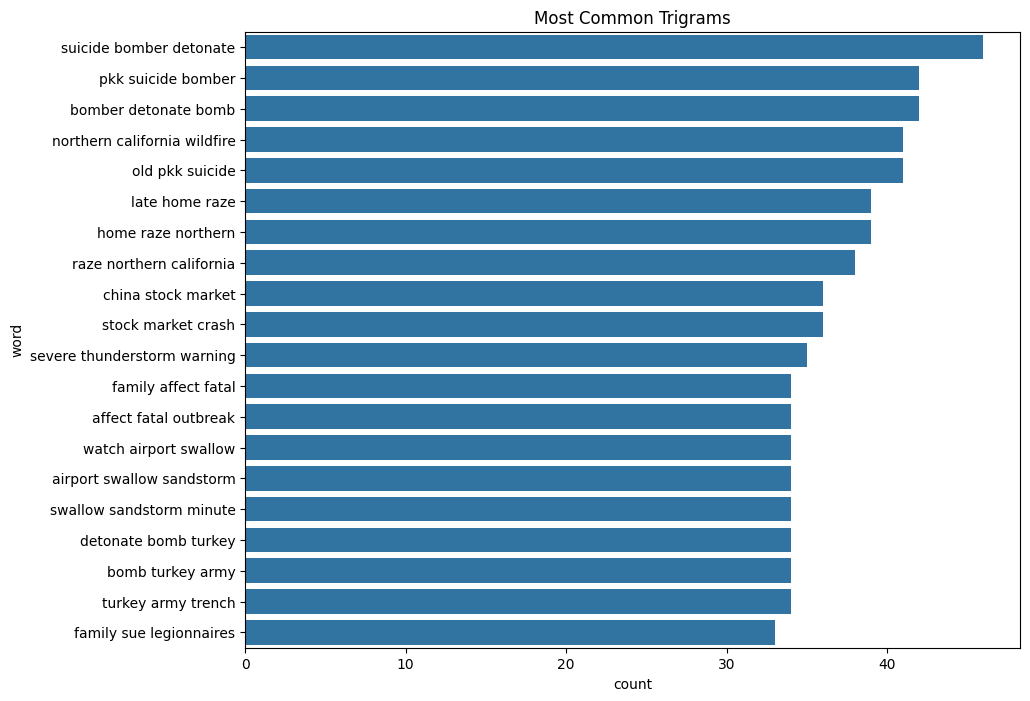

In [10]:
# триграммы
plot_ngrams(3, 'Most Common Trigrams')

### 4. Токенизация

- NLTK Tokenization

Один из методов токенизации у NLTK - это 'word_tokenize', то есть разделение текста на отдельные слова. Он делит на токены на основе пробелов и знаков препинания.

In [11]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

data['word_tokens'] = data['text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


- BPE (RoBERTa Tokenization)

RoBERTa использует метод Byte-Pair Encoding (BPE), который заключается в объединение наиболее часто встречающихся пар символов в токены, что позволяет работать с редкими словами. Каждый токен преобразуется в уникальный идентификатор из словаря модели. Также RoBERTa учитывает контекст, так как сохраняет информацию о токенах с исходной последовательностью символов.

In [12]:
from transformers import RobertaTokenizer

bpe_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
data['bpe_tokens'] = data['text'].apply(lambda x: bpe_tokenizer.tokenize(x))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

- BertTokenizer

BertTokenizer использует WordPiece токенизацию, где разбиваются слова на подслова. Также каждый токен преобразуется в уникальный идентификатор из словаря модели.

In [13]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
data['bert_tokens'] = data['text'].apply(lambda x: bert_tokenizer.tokenize(x))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### 5. Векторизация с помощью TfidfVectorizer

Tfidf преобразует текст в числовые векторы, а именно создает матрицу слов и документов, где каждый элемент представляет частоту слова в документе.


- NLTK Tokenization

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# объединение токенов обратно в строки
data['nltk_text'] = data['word_tokens'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['nltk_text'])

- BPE (RoBERTa Tokenization)

In [15]:
# объединение токенов обратно в строки
data['bpe_text'] = data['bpe_tokens'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['bpe_text'])

- BertTokenizer

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# объединение токенов обратно в строки
data['bert_text'] = data['bert_tokens'].apply(lambda tokens: ' '.join(tokens))

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(data['bert_text'])

### 6. Эмбеддинги FastText и предобученная DistilBertModel

FastText разбивает слово на n-граммы. Векторное представление слова у FastText получается путем усреднения эмбеддингов всех n-грамм, составляющих это слово.

DistilBERT основан на методе knowledge distillation, что позволяет уменьшить размер модели и сократить вычислительные ресуры, но при этом работать не сильно хуже, чем сам BERT.


- NLTK Tokenization

In [17]:
import gensim.downloader as api
import numpy as np

fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')

# получение среднего вектора
def document_vector(doc, model):
    doc = [word for word in doc if word in model]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in doc], axis=0)

data['fasttext_vector'] = data['word_tokens'].apply(lambda tokens: document_vector(tokens, fasttext_vectors))

[==================================================] 100.0% 958.5/958.4MB downloaded


In [18]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch

distilbert_tokenizer_nltk = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model_nltk = DistilBertModel.from_pretrained('distilbert-base-uncased')

# получение эмбеддингов
def get_distilbert_embeddings_nltk(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

data['distilbert_vector_nltk'] = data['nltk_text'].apply(lambda x: get_distilbert_embeddings_nltk(x, distilbert_tokenizer_nltk, distilbert_model_nltk))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

- BPE (RoBERTa Tokenization)

In [22]:
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')

# получение среднего вектора
def document_vector(doc, model):
    doc = [word for word in doc if word in model]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in doc], axis=0)

data['fasttext_vector'] = data['bpe_tokens'].apply(lambda tokens: document_vector(tokens, fasttext_vectors))

In [24]:
distilbert_tokenizer_roberta = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model_roberta = DistilBertModel.from_pretrained('distilbert-base-uncased')

# получение эмбеддингов
def get_distilbert_embeddings_roberta(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

data['distilbert_vector_roberta'] = data['bpe_text'].apply(lambda x: get_distilbert_embeddings_roberta(x, distilbert_tokenizer_roberta, distilbert_model_roberta))

- BertTokenizer

In [28]:
fasttext_vectors = api.load('fasttext-wiki-news-subwords-300')

# получение среднего вектора
def document_vector(doc, model):
    doc = [word for word in doc if word in model]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean([model[word] for word in doc], axis=0)

data['fasttext_vector'] = data['bert_tokens'].apply(lambda tokens: document_vector(tokens, fasttext_vectors))

In [29]:
distilbert_tokenizer_bert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model_bert = DistilBertModel.from_pretrained('distilbert-base-uncased')

# получение эмбеддингов
def get_distilbert_embeddings_bert(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().detach().numpy()

data['distilbert_vector_bert'] = data['bert_text'].apply(lambda x: get_distilbert_embeddings_bert(x, distilbert_tokenizer_bert, distilbert_model_bert))

### 7. Визуализация получившихся эмбеддингов

- NLTK Tokenization

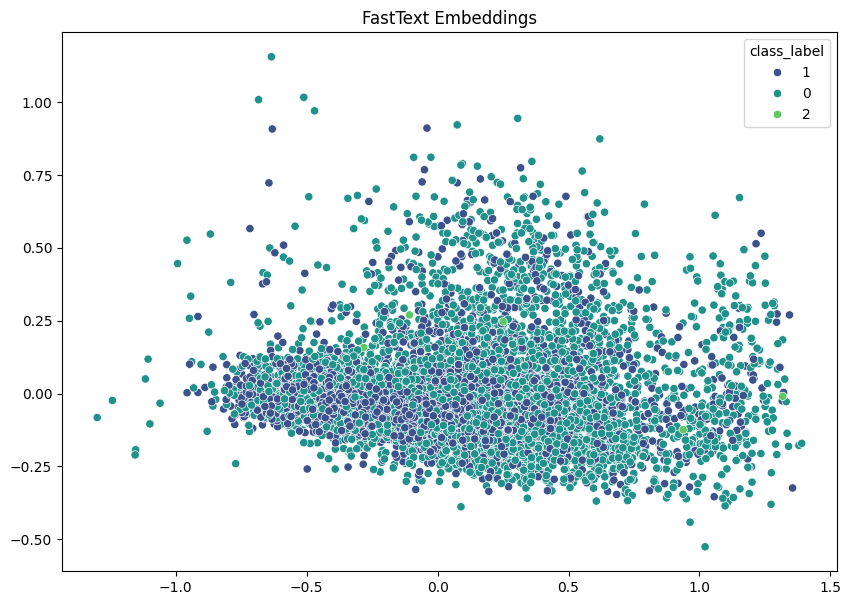

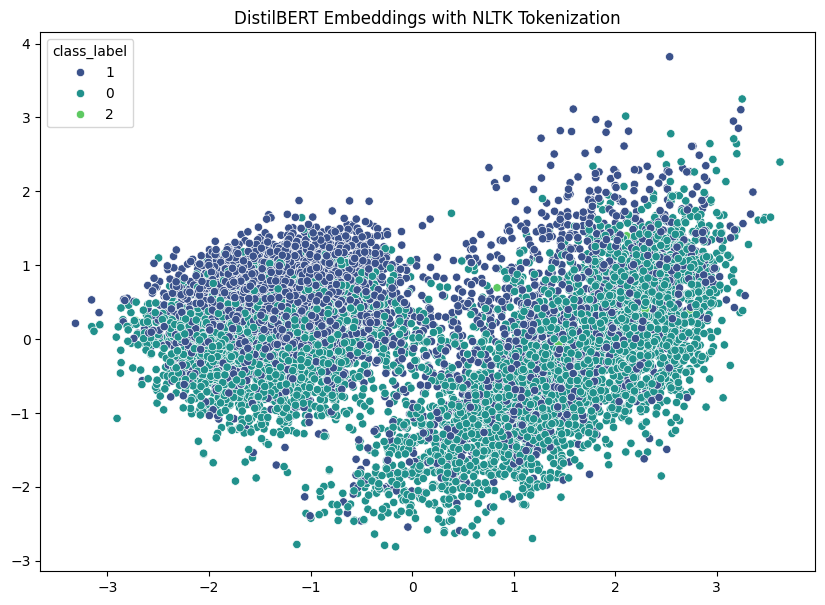

In [27]:
from sklearn.decomposition import PCA

def visualize_embeddings(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], hue=labels, palette='viridis')
    plt.title(title)
    plt.show()

class_column_name = 'class_label'

# FastText
fasttext_embeddings = np.stack(data['fasttext_vector'].values)
visualize_embeddings(fasttext_embeddings, data[class_column_name], 'FastText Embeddings')

# DistilBERT
distilbert_embeddings_nltk = np.stack(data['distilbert_vector_nltk'].values)
visualize_embeddings(distilbert_embeddings_nltk, data[class_column_name], 'DistilBERT Embeddings with NLTK Tokenization')

### Описание результатов с NLTK Tokenization:

FastText не показал явного разделения классов, эмбеддинги выглядят смешанными и плотно распределенными.
DistilBERT показал явное разделение классов, классы образуют отдельные кластеры, что говорит о более высоком качестве эмбеддингов.

- BPE (RoBERTa Tokenization)

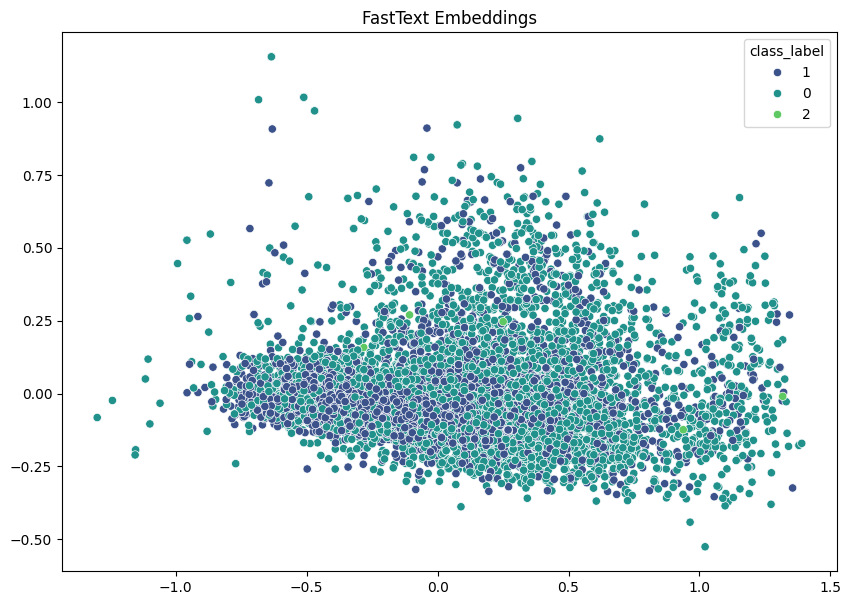

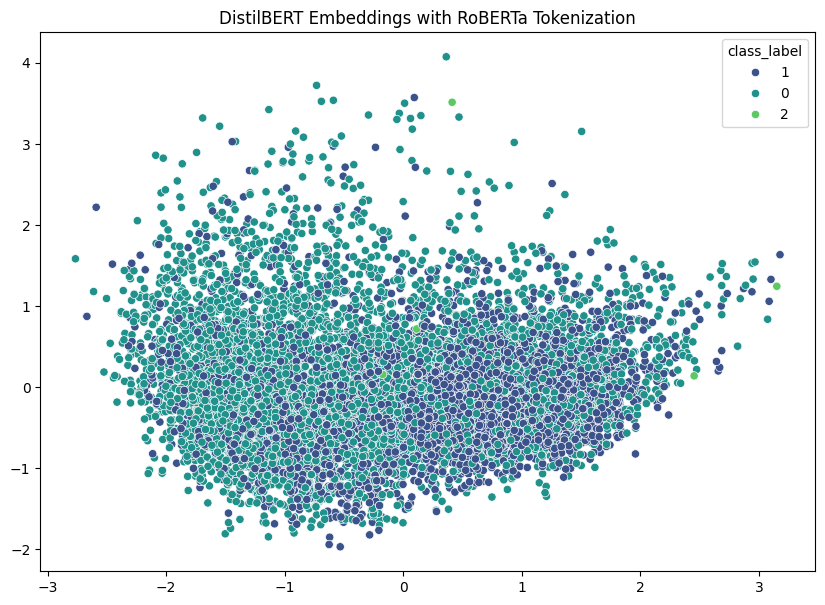

In [25]:
def visualize_embeddings(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], hue=labels, palette='viridis')
    plt.title(title)
    plt.show()

class_column_name = 'class_label'

# FastText
fasttext_embeddings = np.stack(data['fasttext_vector'].values)
visualize_embeddings(fasttext_embeddings, data[class_column_name], 'FastText Embeddings')

# DistilBERT
distilbert_embeddings_roberta = np.stack(data['distilbert_vector_roberta'].values)
visualize_embeddings(distilbert_embeddings_roberta, data[class_column_name], 'DistilBERT Embeddings with RoBERTa Tokenization')

### Описание результатов с BPE (RoBERTa Tokenization)

FastText показал идентичные результаты, как у NLTK.
DistilBERT продемонстрировал некоторое разделение классов, но не такое явное, как с NLTK токенизацией. Классы не образуют четких кластеров.


- BertTokenizer

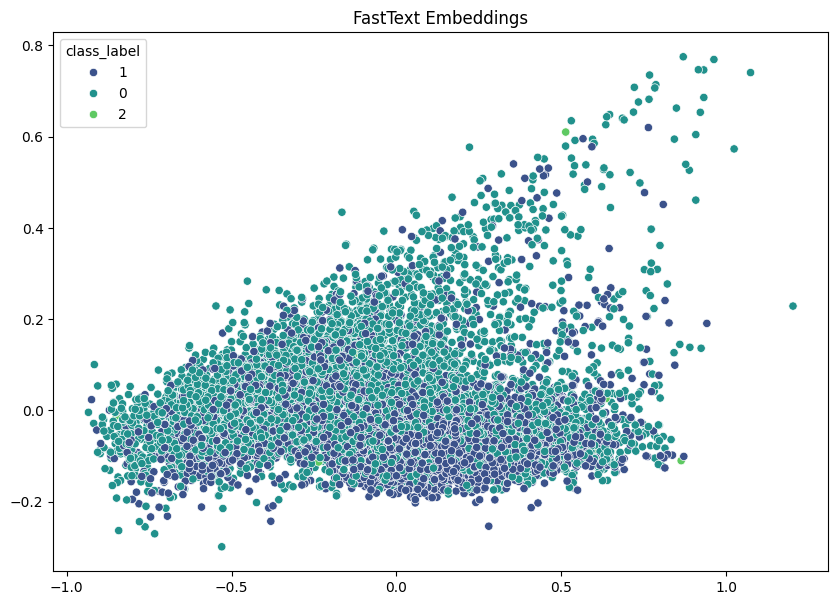

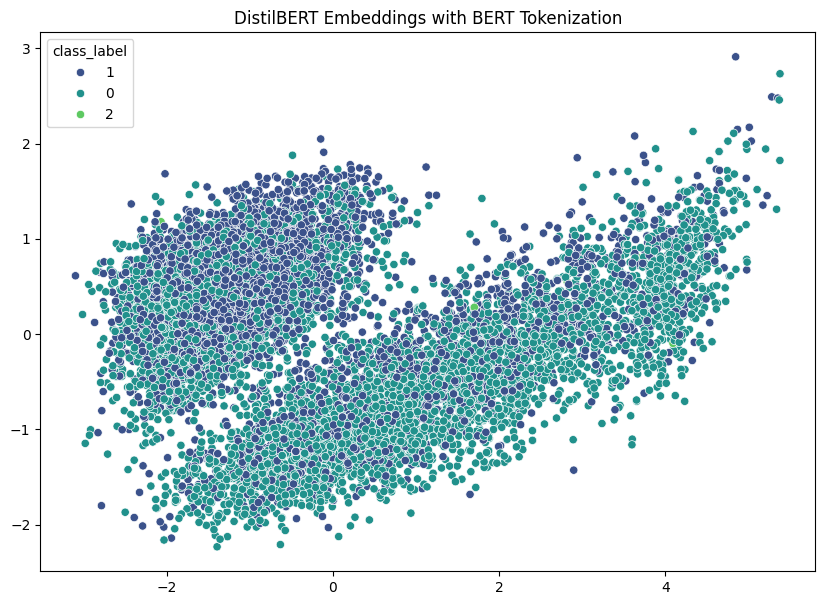

In [30]:
def visualize_embeddings(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], hue=labels, palette='viridis')
    plt.title(title)
    plt.show()

class_column_name = 'class_label'

# FastText
fasttext_embeddings = np.stack(data['fasttext_vector'].values)
visualize_embeddings(fasttext_embeddings, data[class_column_name], 'FastText Embeddings')

# DistilBERT
distilbert_embeddings_bert = np.stack(data['distilbert_vector_bert'].values)
visualize_embeddings(distilbert_embeddings_bert, data[class_column_name], 'DistilBERT Embeddings with BERT Tokenization')

### Описание результатов с BERT Tokenization:

FastText выглядит смешанным, без явного разделения классов, что схоже с результатами для NLTK и RoBERTa.
DistilBERT показал явное разделение классов, классы образуют отдельные кластеры, что указывает на высокую эффективность токенизации BERT в сочетании с DistilBERT.

### Заключение

Использование DistilBERT с любой из токенизаций (NLTK, RoBERTa и BERT) дает неплохие результаты по разделению классов, но NLTK и BERT показали немного лучше результаты по сравнению с RoBERTa. Возможно, при использовании другого эмбеддинга (например, GloVe) результаты были бы лучше.